# RadioML dataset - 2016.10A
----

- It is a synthetic dataset generated with GNU Radio.
- Consists of 11 modulations (8 digital and 3 analog) - E.g. - `8PSK`, `QPSK`, etc. Along with varying SNR ratios.
- [Source](https://www.deepsig.ai/datasets).

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,7)
plt.rcParams.update({'font.size': 15})
plt.style.use('fivethirtyeight')

In [2]:
# Import the pickled raw file
path = "/Volumes/DHIRAJ/B.Tech/Project-1/RML2016.10a_dict.pkl"
with open(path, 'rb') as pic_file:
    data = pickle.load(pic_file, encoding='latin1')

## About the dataset -
---

In [25]:
list(data.keys())

[('QPSK', 2),
 ('PAM4', 8),
 ('AM-DSB', -4),
 ('GFSK', 6),
 ('QAM64', 8),
 ('AM-SSB', 12),
 ('8PSK', 8),
 ('8PSK', 12),
 ('QAM64', -6),
 ('QAM16', 2),
 ('QAM16', -20),
 ('PAM4', -6),
 ('WBFM', -18),
 ('AM-DSB', 16),
 ('CPFSK', 10),
 ('WBFM', 6),
 ('BPSK', 4),
 ('BPSK', -2),
 ('QPSK', -20),
 ('CPFSK', -8),
 ('AM-SSB', 6),
 ('QAM64', -20),
 ('QAM16', 12),
 ('GFSK', -20),
 ('AM-SSB', -12),
 ('CPFSK', 0),
 ('AM-DSB', 6),
 ('BPSK', -16),
 ('QPSK', -6),
 ('8PSK', -12),
 ('CPFSK', -18),
 ('BPSK', -10),
 ('QPSK', 8),
 ('PAM4', 14),
 ('AM-DSB', -10),
 ('GFSK', 12),
 ('QAM64', 2),
 ('WBFM', -4),
 ('AM-SSB', -18),
 ('QAM64', -4),
 ('GFSK', -4),
 ('AM-DSB', 8),
 ('PAM4', -16),
 ('QPSK', -16),
 ('BPSK', 16),
 ('8PSK', -8),
 ('CPFSK', 16),
 ('WBFM', 0),
 ('QPSK', 6),
 ('BPSK', 14),
 ('AM-DSB', -8),
 ('GFSK', -10),
 ('CPFSK', -2),
 ('AM-SSB', 8),
 ('GFSK', 18),
 ('QAM16', 6),
 ('QAM16', -16),
 ('QAM64', 18),
 ('AM-SSB', -2),
 ('CPFSK', 6),
 ('BPSK', 0),
 ('BPSK', -6),
 ('8PSK', -14),
 ('CPFSK', -12),

In [43]:
snr_vals, mod_classes = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])
print("Data is originally stored in a dictionary format with keys as (modulation, SNR value).")
print(f"Input Data shape: {data[('QAM16', 18)].shape}")
print(f"Total labels: {len(data.keys())}")
print(f"Modulation Techniques: {mod_classes}")
print(f"SNR values: {snr_vals}")

Data is originally stored in a dictionary format with keys as (modulation, SNR value).
Input Data shape: (1000, 2, 128)
Total labels: 220
Modulation Techniques: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
SNR values: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## Exploratory Data analysis
---

### Different signal representations
---

In [17]:
def plot_data(samples, mod_name, SNR, plot_type="iq"):
    I_values = samples[0]
    Q_values = samples[1]
    signal = I_values + 1j * Q_values
    if plot_type == "iq":
        plt.plot(I_values, label="I values", c='r', linewidth=3, alpha=0.75)
        plt.plot(Q_values, label="Q values", linewidth=3, alpha=0.75)
        plt.plot(np.abs(signal), label="Amplitude", c='b', linewidth=4, alpha=0.85)
        plt.title(f"IQ/Amplitude Vs Time{mod_name}-{str(SNR)}")
        plt.xlabel("Time in $\mu s$")
        plt.legend()
        plt.show()
    if plot_type == "ph_amp":
        plt.subplot(1,2,1)
        plt.suptitle(f"Amplitude and Phase Vs Time ({mod_name}-{str(SNR)})")
        plt.plot(np.abs(signal), label="Amplitude", c='b', linewidth=3, alpha=0.75)
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.angle(signal), label="Phase", c='g', linewidth=3, alpha=0.75)
        plt.legend()
        plt.show()
    if plot_type == "spec":
        spec = plt.specgram(signal,  Fs=1000, mode='magnitude')
        plt.colorbar()
        plt.title(f"{mod_name}-{str(SNR)}")
        plt.show()
# d = plt.magnitude_spectrum(c, Fs=1000)
# plt.show()

NameError: name 'c' is not defined

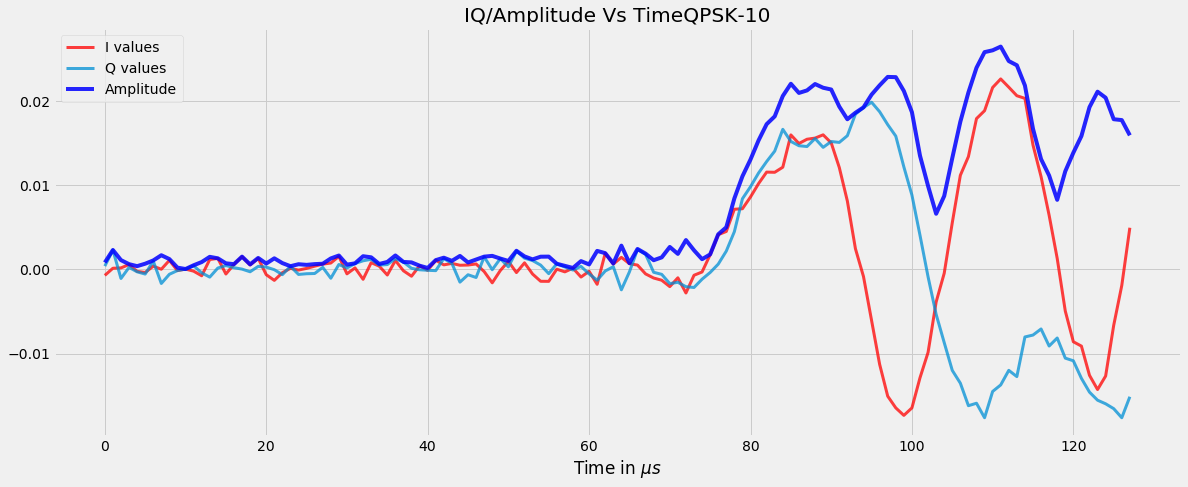

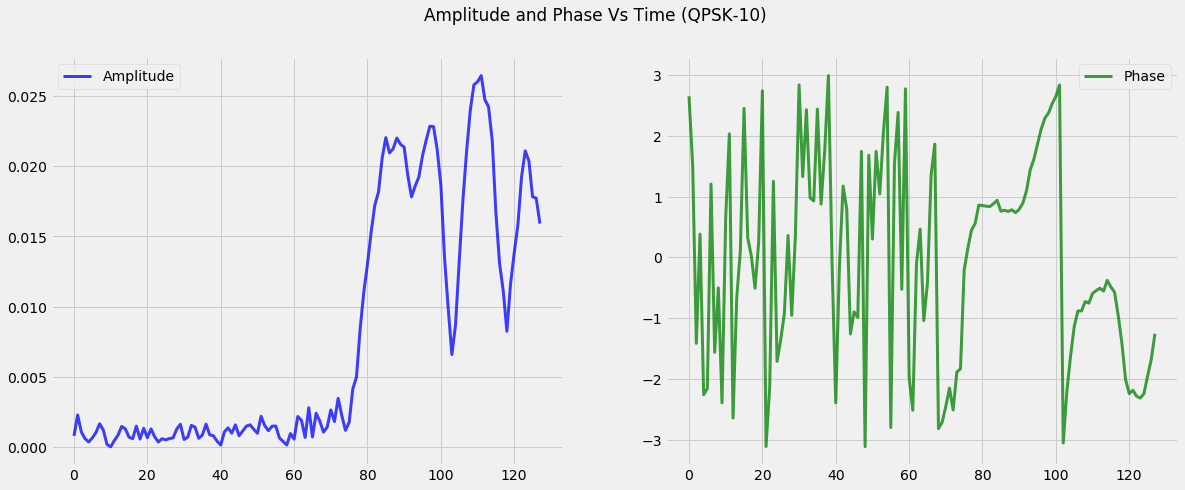

/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/matplotlib/mlab.py:1246: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=128).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


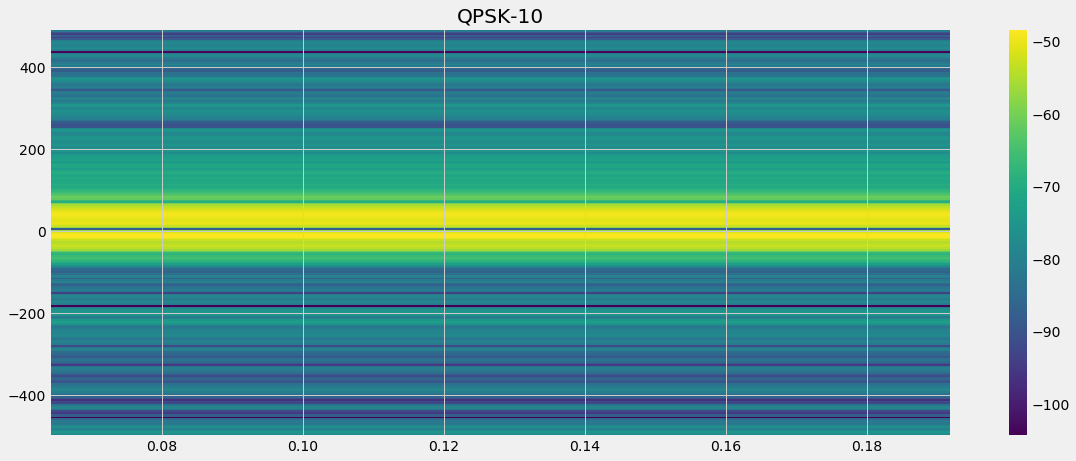

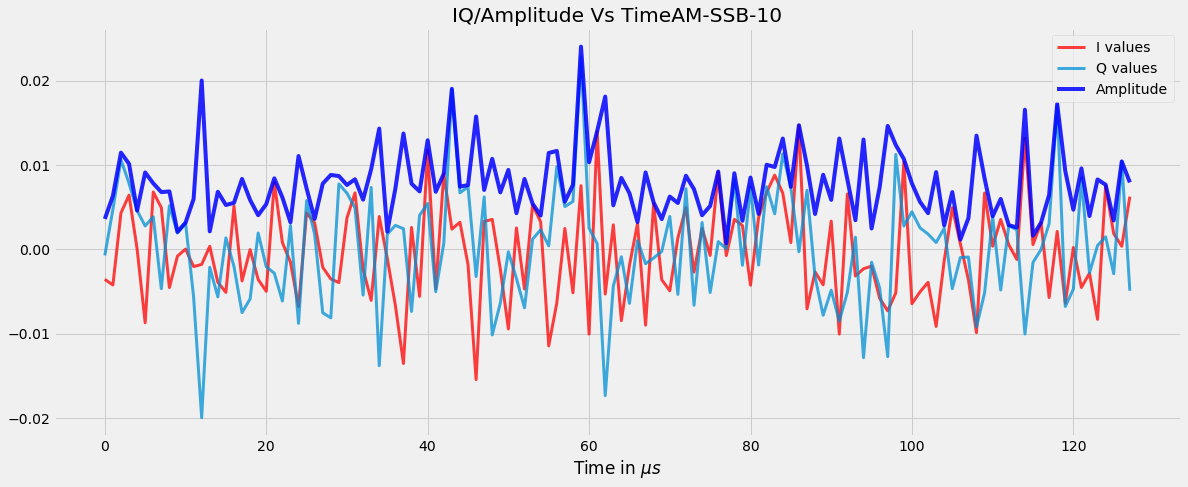

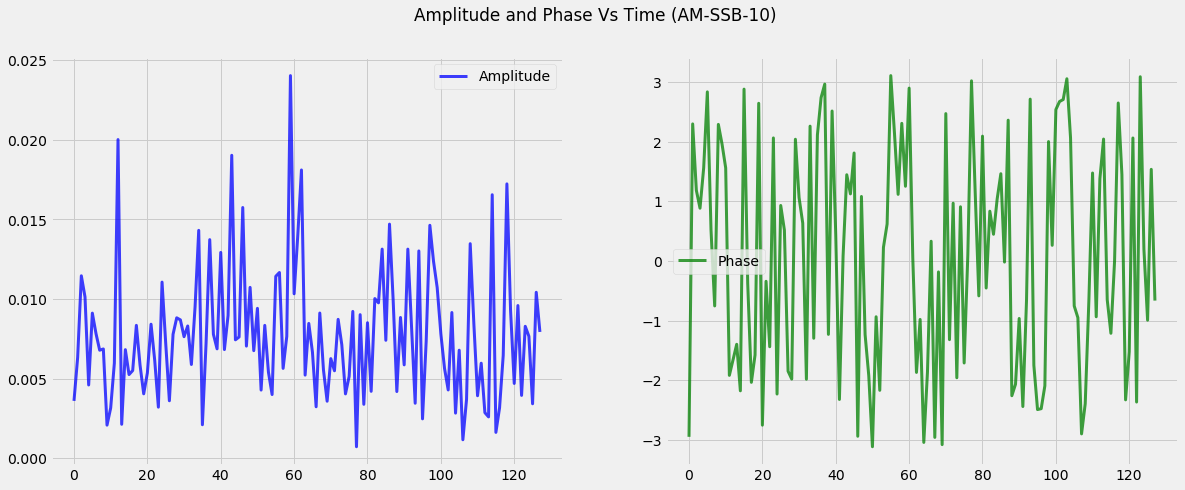

In [18]:
plot_data(data[("QPSK", 10)][0], "QPSK", 10, "iq")
plot_data(data[("QPSK", 10)][0], "QPSK", 10, "ph_amp")
plot_data(data[("QPSK", 10)][0], "QPSK", 10, "spec")
plot_data(data[("AM-SSB", 10)][0], "AM-SSB", 10, "iq")
plot_data(data[("AM-SSB", 10)][0], "AM-SSB", 10, "ph_amp")

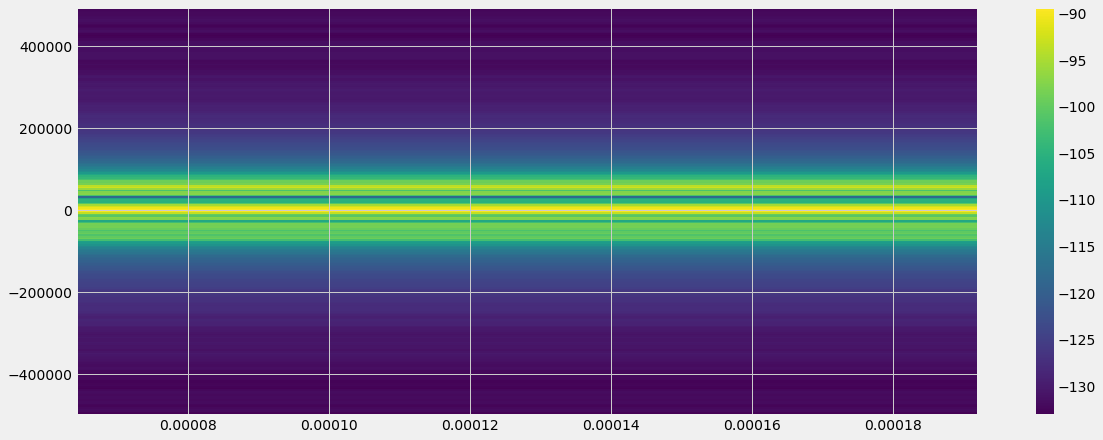

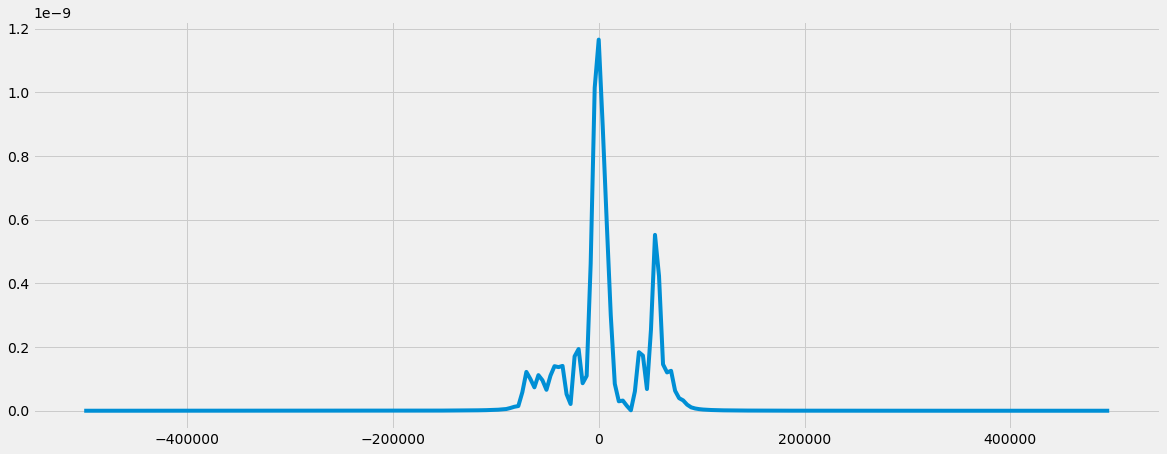

In [19]:
ex = data[("QAM16", 18)][0]
i = ex[0]
q = ex[1]
c = i + 1j * q
s = plt.specgram(c,  Fs=1000000, mode='psd')
plt.colorbar()
plt.show()
plt.plot(s[1], s[0])
plt.show()

In [28]:
data[('BPSK', 4)][0][0]

(128,)